# GRU (LSTM/RNN) Architecture and Training

We have time series data, so we should use a time series based neural network.  
Recurrent NNs are a standard sequence based model, but suffers from vanishing gradient etc.  
Alternatively LSTM (long short term memory) often out performs RNNs, and are better at learning long term dependencies.  
This would make an LSTM ideal for us, where we want the model to learn how to take into account say previous years and stuff.  
However, LSTMs are somewhat complicated, and we don't have a ton of data.  
An alternative is a GRU (grated recurrent unit), which is a little simpler than a default LSTM, which may be desirable given our small dataset.  
Because GRUs are trained on an arbituary sequence of inputs, the various training stages can be simplified significantly.  


## General Architectures

The model architecture would be quite simple.
First is a single GRU layer, 36 dim input (for each day), 256 dim hidden layer (to hopefully accomodate long sequences), 1 GRU layer (just for simplicity), with some drop out.  
This GRU layer will then feed into a single linear layer 256 -> 2.  
So the network will look like Dx36 -> GRU -> 256 -> 2, where D is the number of days.  

## Training Phases

Because sequences can be of arbitrary length, we can just have the training phases be of increasingly long periods of time.

1. Weekly (7 days). Should allow network to learn how to translate climate variables to approximate daily elevations.
2. Monthly (31 days). "    " learn how climate variables across a whole month can effect elevation.
3. Semiannual (186 days) "    " learn more across a longer time period.
4. Annual (365 days)
5. Biannual (730 days)
6. Semidecade (1825)
7. Decade (3650 days)
8. Bidecade (7300 days)

The number of observations in each training phase are:

1. 14603
2. 14579
3. 14424
4. 14245
5. 13880
6. 12785
7. 10960
8. 7310


<!-- # Model Architectures and Training Phases

Since we have limited data, I have created three datasets that go from long to wide.  

* Daily: Elevation, climate variables aggregated across the 9 watershed segments.
* Monthly: min/max elevation with 31 instances of the 3 climate variable aggregated across the 9 watershed segments.
* Yearly: min/max elevation, with 12 instances of 31 days with 3 climate variables aggregated across the 9 watershed segments  

## General architectures

Simple linear feedforward NNs.  
Likely a 256 -> 128 -> 64 -> 32 as the main body of the network.  
For an AE, this can then be reversed: 256 -> 128 -> 64 -> 32 -> 64 -> 128 -> 256.  
Since we have different temporal resolutions of data, the input and output layers will be adjusted accordingly  


## Phases

1. Daily, AE.
    * Using the daily climate variables train an AE to learn a representation of the data while we have the most amount if observations.
    * Architecture: 27 -> (256,128,64,32,64,128,256) -> 27
2. Daily, Single Elevation.
    * Using the daily variables, learn to predict daily elevation.
    * Part 1, just learn the output layer.
    * Architecture: [27 -> (256,128,64,32)] -> 1 (freeze what we learned before, just learn output)
    * Part 2, unfreeze the other layers to learn more information.
    * Architecture: 27 -> (256,128,64,32) -> 1 (Unfreeze all layers)
3. Monthly, Min/Max Elevation.
    * Using monthly variables, learn to predict monthly min/max.
    * since we know a daily (27) representation, repeat those weights 31 times to initialize the 31*27=837 input.
    * Part 1, first learn the new input layer.
    * Architecture: 837 -> [(256,128,64,32) -> 1]. (we will use average min/max to be more consistent with the final output layer).
    * Part 2, Now learn the min/max output.
    * Architecture: [837 -> (256,128,64,32)] -> 2.
    * Part 3, Unfreeze whole network.
    * Architecture 837 -> (256,128,64,32) -> 2.
4. Annual, Min/Max Elevation.
    * Now finally using the annual data, predict min/max.
    * First, repeat 837*12=10044 to initialize new input layer.
    * Part 1, learn new input layer.
    * Architecture: 10044 -> [(256,128,64,32)->2]. (Note we freeze everything else).
    * Part 2, learn everything else.
    * Architecture: 10044 -> (256, 128, 64, 32) -> 2. Unfreeze everything. -->


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.init as init

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/tmp/ipykernel_6077/3725336831.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Set up data

In [3]:
class BearLakeDataset(Dataset):
    def __init__(self, input_df, period_days):
        super().__init__()
        self.df = input_df.copy()
        self.df['Elevation'] = self.df['Elevation'].interpolate(method='linear')
        self.scaler = StandardScaler()
        self.df.iloc[:, 2:] = self.scaler.fit_transform(self.df.iloc[:, 2:].values)
        self.period = period_days
        # Calculate the water year min/max if the period is longer than 365 days
        # if period_days >= 365:
        #     self.tmp_df = self.df[['date', 'Elevation']].copy()
        #     self.tmp_df['month'] = self.tmp_df['date'].dt.month
        #     self.tmp_df['date']  = self.tmp_df['date'].dt.year
        #     # Convert year to water year
        #     def water_year(row):
        #         if row['month'] >= 10:  # October is month 10
        #             return pd.Period(year=row['date'] + 1, freq='Y-SEP')
        #         else:
        #             return pd.Period(year=row['date'], freq='Y-SEP')
        #     self.tmp_df['date'] = self.tmp_df.apply(water_year, axis=1)
        #     # Find min/max
        #     self.tmp_df = self.tmp_df.groupby('date')['Elevation'].agg(['min', 'max']).reset_index()

    def __len__(self):
        len = self.df.shape[0] - self.period
        return len + 1
    
    def __getitem__(self, index):
        X = self.df.iloc[index:index+self.period, 2:].values
        # if self.period < 365:
        Y = self.df.iloc[index:index+self.period, 1].values
        y_m = Y.min()
        y_M = Y.max()
        Ys = np.array([y_m, y_M])
        # else:
        #     last_year = self.df.iloc[index + self.period-1].date.year
        #     Y = self.tmp_df[self.tmp_df.date.dt.year == last_year]
        #     y_m = Y['min'].values
        #     y_M = Y['max'].values
        #     Ys = np.array([y_m, y_M]).flatten()
        return torch.tensor(X, dtype=torch.float32), torch.tensor(Ys, dtype=torch.float32)


# Set up model code

In [4]:
# Define the GRU model
class GRU_MME(nn.Module):
    def __init__(self, input_size=80, hidden_size=32, output_size=2, num_layers=1, dropout=0.5,
                 scale=20, shift=5914.26):
        super(GRU_MME, self).__init__()
        self.scale = scale
        self.shift = shift

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # self.bn = nn.BatchNorm1d(hidden_size)
        self.act = nn.Tanh()
        self.do = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.serial = nn.Sequential(
            self.do, self.act, self.fc, self.act
        )

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        # Forward pass through GRU layer
        out, _ = self.gru(x, h0.detach())
        # linear_outputs = torch.stack([self.scale * self.serial(out[:, i, :]) + self.shift for i in range(out.size(1))], dim=1)
        linear_outputs = self.scale * self.serial(out) + self.shift
        std, mean = torch.std_mean(linear_outputs, dim=1)
        # out = self.scale * self.serial(out[:, -1, :]) + self.shift
        return mean, std

# Promising Model Configurations

training: period min/max (instead of last wateryear min/max)
testing: last 3 years
Period: 3 years
Epochs: 75
lr: 

In [5]:
# Set up training and testing sets
period = 3*365
daily = pd.read_csv("/home/ScoutJarman/Code/ILWA/data/other/Daily.csv", parse_dates=['date'])
daily_train = daily.iloc[:-period]
daily_test = daily.iloc[-period:]
dataset_test = BearLakeDataset(daily_test, period_days=period)
dataloader_test = DataLoader(dataset_test, batch_size=period, shuffle=False)


# Define hyperparameters
num_epochs = 100
batch_size = 1024
learning_rate = 5e-4
torch.manual_seed(789)
device_id = 0
if torch.cuda.is_available():
    device = f"cuda:{device_id}"
else:
    device = 'cpu'


# Instantiate the GRU model
model = GRU_MME()
model.to(device)
torch.autograd.set_detect_anomaly(True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
training_loss_all = []
training_loss_epoch = []
testing_loss_epoch = []
try:
    for i, period in enumerate([3*365]):
        
        # Set up dataloaders and sets
        print(f"Training on {period} days for {num_epochs} epochs...")
        dataset_train = BearLakeDataset(daily_train, period_days=period)
        dataloader = DataLoader(dataset_train, batch_size=int(batch_size), shuffle=True)
        

        # Train over epochs
        tmp_epoch_loss = []
        for epoch in range(num_epochs):
            model.train()
            pbar = tqdm(dataloader)
            for batch_X, batch_Ys in pbar:
                batch_X = batch_X.to(device)
                batch_Ys = batch_Ys.to(device)
                # Forward pass
                outputs, std = model(batch_X)
                # Compute the loss
                loss = criterion(outputs, batch_Ys)
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_description(f"Loss: {loss.item():.4f}")
                training_loss_all.append(loss.item())
                tmp_epoch_loss.append(loss.item())
            training_loss_epoch.append(np.mean(tmp_epoch_loss))

            # Eval model
            model.eval()
            with torch.no_grad():
                tmp_loss = 0
                for batch_X, batch_Ys in dataloader_test:
                    batch_X = batch_X.to(device)
                    batch_Ys = batch_Ys.to(device)
                    outputs, std = model(batch_X)
                    
                    loss = criterion(outputs, batch_Ys)
                    tmp_loss += loss.item()
                testing_loss_epoch.append(tmp_loss/len(dataloader_test))
            print(f"Testing loss: {testing_loss_epoch[-1]:.4f}")
            # Save the trained model if needed
            torch.save(model.state_dict(), f'gru_model_{period}.pth')
except Exception as e:
    print(e)
    torch.save(model.state_dict(), f'gru_model_final.pth')
finally:
    torch.save(model.state_dict(), f'gru_model_final.pth')

Training on 1095 days for 100 epochs...


Loss: 27.2427: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 7.6540


Loss: 20.2204: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 5.1874


Loss: 17.8169: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 6.2454


Loss: 17.3621: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 6.4859


Loss: 18.2585: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 5.5750


Loss: 16.9237: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 5.5028


Loss: 15.3045: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 5.6292


Loss: 17.1347: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 5.6393


Loss: 14.9597: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.7079


Loss: 15.1067: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.3597


Loss: 11.6591: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 3.2346


Loss: 7.7100: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 3.7223


Loss: 6.2146: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 2.7523


Loss: 4.2851: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 3.0556


Loss: 3.3444: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 2.9136


Loss: 2.8455: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.9689


Loss: 2.3129: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.6860


Loss: 2.9410: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 3.5481


Loss: 2.1163: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 5.3861


Loss: 2.1005: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 5.4045


Loss: 1.9330: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 9.3693


Loss: 1.8254: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 7.5520


Loss: 1.9131: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Testing loss: 7.8446


Loss: 1.7174: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 8.6148


Loss: 1.6592: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 8.8188


Loss: 1.9160: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 8.7679


Loss: 1.7484: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 9.6400


Loss: 1.5259: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 10.9793


Loss: 1.1979: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 9.8723


Loss: 1.4154: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 9.9909


Loss: 1.5278: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 12.4594


Loss: 1.2333: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 9.0094


Loss: 1.6009: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 8.6488


Loss: 1.2129: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 10.0387


Loss: 1.0757: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 9.7528


Loss: 1.1439: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 8.8845


Loss: 1.2779: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 10.1741


Loss: 1.1396: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 7.7811


Loss: 1.0594: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 8.7174


Loss: 1.1267: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 5.3074


Loss: 1.1212: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 9.2204


Loss: 0.9836: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 4.9942


Loss: 1.1011: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 7.3108


Loss: 0.9014: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.2140


Loss: 0.8952: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 5.5424


Loss: 0.8707: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.1287


Loss: 0.9386: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.3552


Loss: 0.8713: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.0054


Loss: 0.8859: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 4.2113


Loss: 0.9531: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 3.2647


Loss: 0.9508: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 4.1275


Loss: 1.1657: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 2.8343


Loss: 0.9476: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 3.9824


Loss: 0.8866: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 3.3555


Loss: 1.0926: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 2.9868


Loss: 0.7597: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


Testing loss: 3.6306


Loss: 0.7538: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Testing loss: 3.4604


Loss: 0.9294: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.7628


Loss: 0.9353: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.9427


Loss: 0.7927: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 3.2928


Loss: 0.6785: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.5172


Loss: 0.7154: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.5367


Loss: 0.8221: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.5281


Loss: 0.9119: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


Testing loss: 3.4862


Loss: 0.7174: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.7189


Loss: 0.7650: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 3.3145


Loss: 0.6426: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.8623


Loss: 0.8019: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.7898


Loss: 0.7560: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.6022


Loss: 0.8930: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.6720


Loss: 0.8249: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.7146


Loss: 0.7292: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.7569


Loss: 0.7044: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 2.9967


Loss: 0.7751: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.8086


Loss: 0.6572: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.3233


Loss: 0.8161: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 2.6117


Loss: 0.7118: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 3.2008


Loss: 0.7044: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


Testing loss: 3.6367


Loss: 0.6582: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]


Testing loss: 3.6478


Loss: 0.7729: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 2.5711


Loss: 0.5699: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.0610


Loss: 0.5680: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.8427


Loss: 0.6425: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Testing loss: 3.6223


Loss: 0.5628: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.4045


Loss: 0.5507: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.4857


Loss: 0.7945: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.3247


Loss: 0.6651: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.2868


Loss: 0.5926: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.8046


Loss: 0.6107: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Testing loss: 4.0006


Loss: 0.5682: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Testing loss: 4.5181


Loss: 0.6248: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.9490


Loss: 0.5634: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 4.2051


Loss: 0.4856: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.8543


Loss: 0.5816: 100%|██████████| 13/13 [00:09<00:00,  1.36it/s]


Testing loss: 3.7901


Loss: 0.4973: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 5.1614


Loss: 0.5649: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.7469


Loss: 0.5750: 100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


Testing loss: 3.0639


Loss: 0.6511: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]


Testing loss: 4.3589


Loss: 0.4910: 100%|██████████| 13/13 [00:10<00:00,  1.24it/s]


Testing loss: 5.0226


Loss: 0.5519: 100%|██████████| 13/13 [00:10<00:00,  1.26it/s]

Testing loss: 4.2226


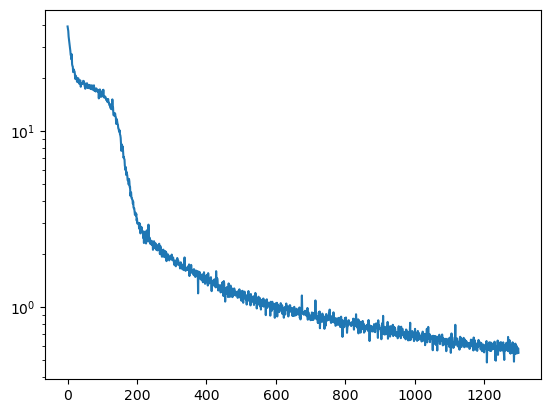

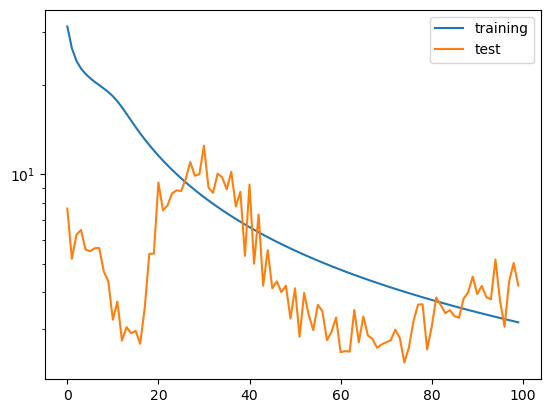

In [10]:
plt.plot(training_loss_all)
plt.yscale("log")
plt.show()

plt.plot(training_loss_epoch, label='training')
plt.plot(testing_loss_epoch, label='test')
plt.legend()
plt.yscale("log")

In [9]:
np.argmin(testing_loss_epoch)

74